In [1]:
import time
import nest
import network
import addons
import helpers
import random
import numpy as np
import pandas as pd 
from network_params import net_dict
from sim_params import sim_dict
from stimulus_params import stim_dict
from scipy.stats import pearsonr

time_start = time.time()


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.7.0
 Built: Apr 15 2024 07:21:32

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



### Computing Synchrony

Measurement of different Synchrony quantities from the spike times obtained in the simulation. 

Measurements:

    - Synchrony (as defined by Potjans Diesmann)

    - Second Synchrony measurement (to make sure there are no bias)

    - Irregularity (CV ISI as defined by Potjans Diesmann)
    
    - LvR (as defined by pronold, 2024)

Irregularity and LvR will have a singular value for each population, and a pdf for each population, aswell

In [2]:
name = addons.analysis_dict["name"]
neuron_id = np.loadtxt("data_og/population_nodeids.dat",dtype=int)
num_neurons = []
for i in range(len(neuron_id)):
    num_neurons = np.append(num_neurons,int(neuron_id[i][1]-neuron_id[i][0]+1))
num_neurons = num_neurons.astype(int)

/home/hyc_1/.local/lib/python3.10/site-packages/numpy/lib/histograms.py:885: RuntimeWarning:invalid value encountered in divide


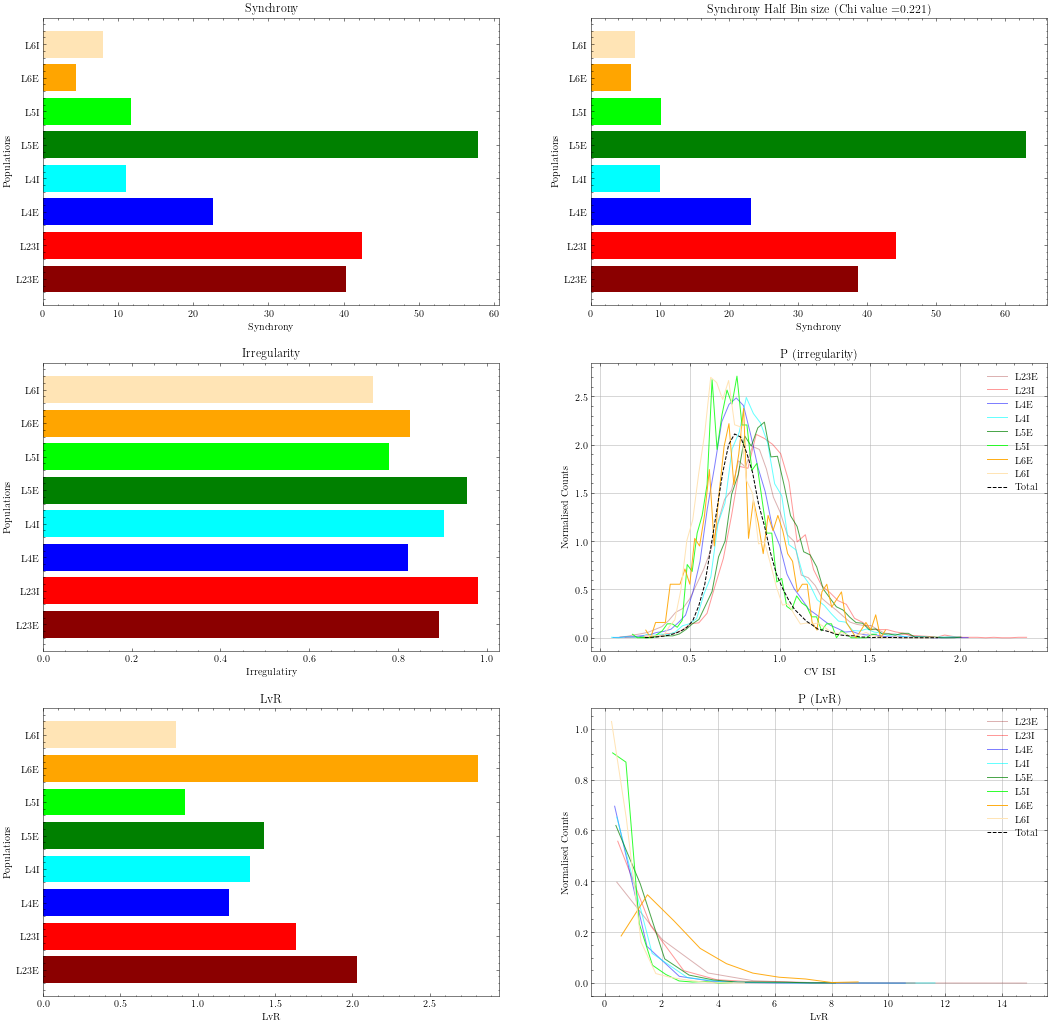

In [3]:
synchrony_pd, synchrony_chi, irregularity, irregularity_pdf, lvr, lvr_pdf, times_s, chi = addons.analyse_synchrony(num_neurons)
addons.plot_synchrony(synchrony_pd,synchrony_chi,irregularity,irregularity_pdf,lvr,lvr_pdf, chi )

In [4]:
np.savetxt(name + "synchrony.dat",synchrony_pd)
np.savetxt(name + "irregularity.dat",irregularity)
np.savetxt(name + "lvr.dat",lvr)

for i in irregularity_pdf:
    np.savetxt(name + "irregularities/irregularity_"+str(i)+".dat",irregularity_pdf[i])
for i in lvr_pdf:
    np.savetxt(name + "lvrs/lvr_"+str(i)+".dat",lvr_pdf[i])
for i in times_s:
    np.savetxt(name + "times/time_"+str(i)+".dat",times_s[i])


### Computing Firing Rates

Measurement of different Firing Rates quantities from the spike times obtained in the simulation. 

Measurements:

    - Firing rate histogram and pdf per population
    
    - Color map of the evolution of firing rates as a function of time

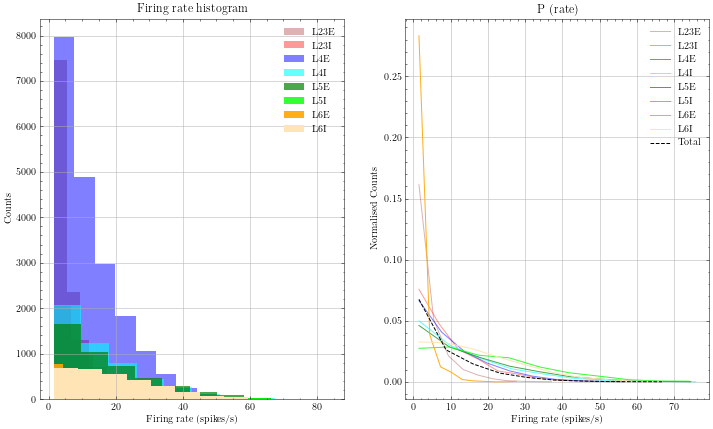

In [5]:
spike_rates = addons.analyse_firing_rates()
addons.plot_firing_rates(spike_rates)

In [6]:
for i in spike_rates:
    np.savetxt(name + "spike_rates/spike_rate_"+str(i)+".dat",spike_rates[i])

### Computing Correlations

Measurement of Correlations between different quantities of the simulation.

For that, it's important to first load all of the data

In [7]:
##### NUMERO DE NEURONAS
voltage_data = addons.load_data("data_og/","voltmeter",)
time_data = voltage_data[0]["time_ms"][0::num_neurons[0]]
#time_data = addons.get_time(voltage_data,num_neurons[0]) 
data_pop = {}
ex_current_pop = {}
in_current_pop = {}
pop_activity = {}
names = ["L23E", "L23I", "L4E", "L4I", "L5E", "L5I", "L6E", "L6I"]
for i in range(len(num_neurons)):
    data_pop[i] = addons.split_data(voltage_data[i], num_neurons[i])

del(voltage_data)
ex_current_data = addons.load_data("data_og/","ex_current",type="Current")
for i in range(len(num_neurons)):
    ex_current_pop[i] = addons.split_data(ex_current_data[i],num_neurons[i],type="Current")

del(ex_current_data)
in_current_data = addons.load_data("data_og/","in_current",type="Current")
for i in range(len(num_neurons)):
    in_current_pop[i] = addons.split_data(in_current_data[i], num_neurons[i],type="Current")

del(in_current_data)

for i in range(len(num_neurons)):
    pop_activity[names[i]] = np.loadtxt(addons.analysis_dict["name"]+"/pop_activities/pop_activity_"+str(i)+".dat")


(1000.0, 1500.0)

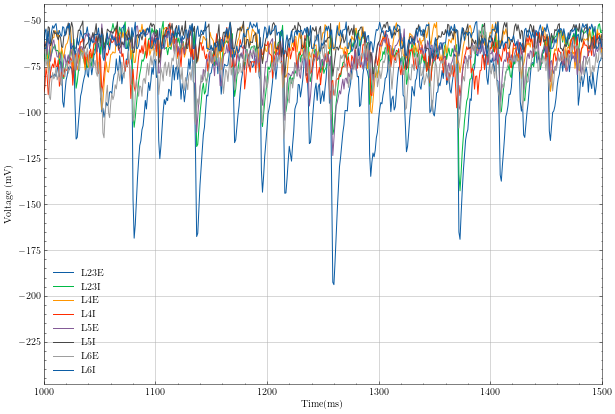

In [16]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(10,7))
pops = ["L23E", "L23I", "L4E", "L4I", "L5E", "L5I", "L6E", "L6I"]

for i in range(len(data_pop)):
    index = random.randrange(len(data_pop[i]))
    plt.plot(time_data,data_pop[i][index], label = pops[i])
    np.savetxt(addons.analysis_dict["name"]+"sample_voltages/neuron_"+str(i)+".dat",data_pop[i][index])
plt.legend()
plt.grid()
plt.xlabel("Time(ms)")
plt.ylabel("Voltage (mV)")
plt.xlim(1000,1500)

In [8]:
data_voltages, data_excitatory, data_inhibitory, times, times_help = addons.prepare_data(data_pop,ex_current_pop,in_current_pop)

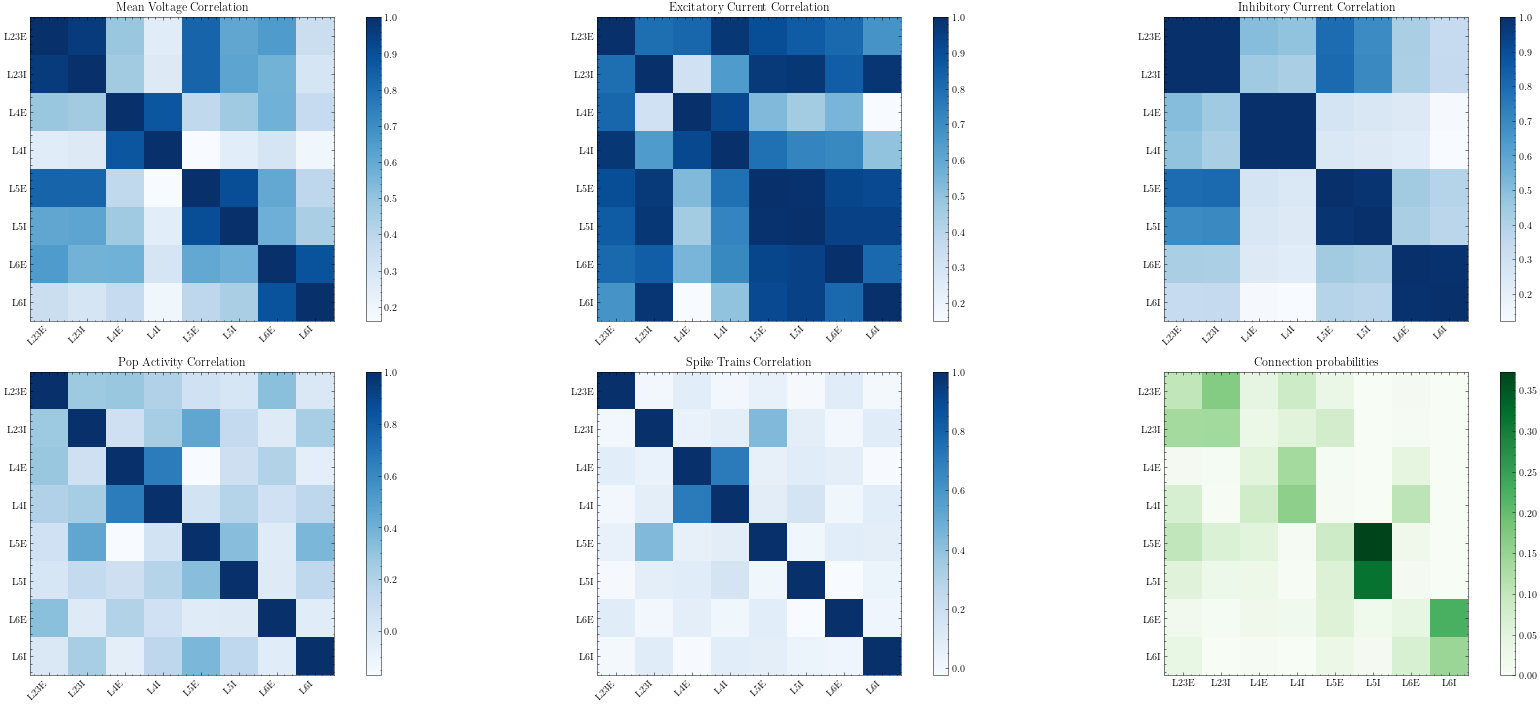

In [10]:
addons.plot_correlations(data_voltages,data_excitatory,data_inhibitory,pop_activity,times)

### Computing Cross-Correlations

We are going to check the Cross-Correlations between one population and all of the rest of a selected quantity, otherwise we'd have too many graphs all at once

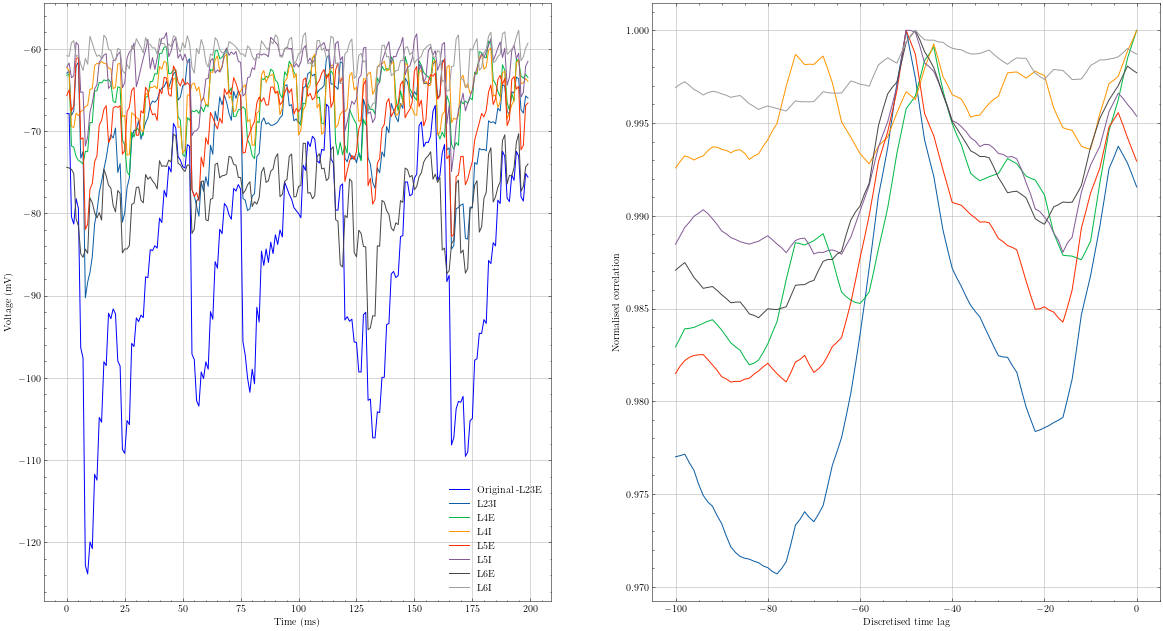

In [11]:
addons.plot_cross_correlation(data_voltages["L23E"],data_voltages,"L23E")

### Computing FFT

FFT of both of the signals: the convolved and the mean voltage

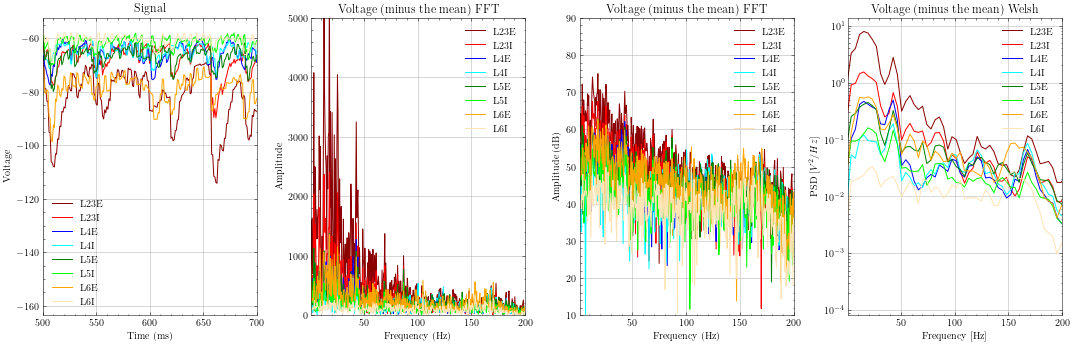

In [13]:
addons.compute_FFT(data_voltages,lim_y=5000,high_log=90,freq_sample=0.001,save=False)

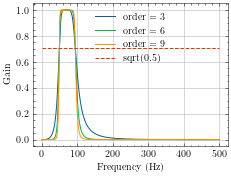

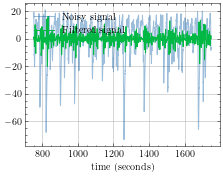

In [14]:
from scipy.signal import butter, lfilter
from scipy.signal import freqz
import matplotlib.pyplot as plt 

# Sample rate and desired cutoff frequencies (in Hz).
fs = 1000
lowcut = 50
highcut = 95
times = time_data

#gamma: 50 95
#alpha: 8 12

# Plot the frequency response for a few different orders.
plt.figure(1)
plt.clf()
for order in [3, 6, 9]:
    b, a = addons.butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = freqz(b, a, fs=fs, worN=2000)
    plt.plot(w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
             '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
#plt.xlim(0,20)
plt.grid(True)
plt.legend(loc='best')
i = "L23E"
# Filter a noisy signal.
plt.figure(2)
plt.clf()
plt.plot(times[addons.analysis_dict["analysis_start"]:addons.analysis_dict["analysis_end"]], data_voltages[i][addons.analysis_dict["analysis_start"]:addons.analysis_dict["analysis_end"]]-np.mean(data_voltages[i][addons.analysis_dict["analysis_start"]:addons.analysis_dict["analysis_end"]]), label='Noisy signal',alpha=0.4)

y = addons.butter_bandpass_filter(data_voltages[i][addons.analysis_dict["analysis_start"]:addons.analysis_dict["analysis_end"]]-np.mean(data_voltages[i][addons.analysis_dict["analysis_start"]:addons.analysis_dict["analysis_end"]]), lowcut, highcut, fs, order=3)
plt.plot(times[addons.analysis_dict["analysis_start"]:addons.analysis_dict["analysis_end"]], y, label='Filtered signal ')
plt.xlabel('time (seconds)')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')


plt.show()

In [15]:
lowcut_alpha = 8
highcut_alpha =12
lowcut_gamma = 50
highcut_gamma = 95

In [16]:
filtered_voltage = addons.filter_signal(data_voltages,lowcut=8,highcut=12,fs=1000)

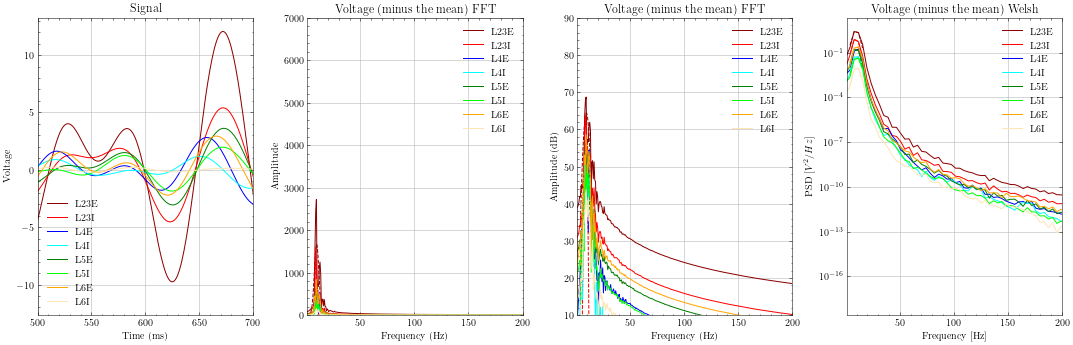

In [22]:
addons.compute_FFT(filtered_voltage,fit=True)

### Signal amplitude response based on the population activity

    Plotting the population activity for the signal, and computing the mean activity for each value, as well as the mean of the maximum points of the signals

In [49]:
import importlib
importlib.reload(addons)

<module 'addons' from '/home/hyc_1/CorticalColumn_Github_3/CorticalColumn_Attempts/addons.py'>

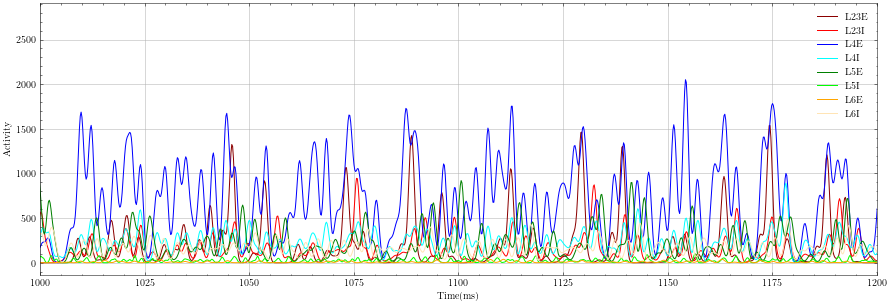

In [50]:
mean_activity, mean_maxima=  addons.plot_activity(pop_activity)

In [51]:
mean_maxima

array([ 458.38139162,  291.72519064, 1123.5403059 ,  355.34614772,
        375.66977023,   45.95296058,   17.63163982,  243.27388156])